<a href="https://colab.research.google.com/github/Mshuning/DNSC-6301/blob/main/DNSC_6301_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**License**

MIT License

Copyright (c) 2021 shuningma@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### Pythons imports

In [1]:
from sklearn import tree                             # sklearn tree model for decision trees
from sklearn.model_selection import train_test_split # for partitioning data
from sklearn.model_selection import cross_val_score  # for cross validation
from sklearn.metrics import roc_auc_score, accuracy_score # to assess decision tree perforamce

# to upload local files
import io
from google.colab import files             

import numpy as np                                   # array, vector, matrix calculations
import pandas as pd                                  # dataFrame handling

from matplotlib import pyplot as plt                 # plotting
import seaborn as sns                                # slightly better plotting  

SEED = 12345                                         # ALWAYS use a random seed for better reproducibility

### Upload training data

In [2]:
# special google colab command to upload a file from your computer
uploaded = files.upload()

Saving credit_line_increase.csv to credit_line_increase (2).csv


In [3]:
type(uploaded)

dict

In [4]:
uploaded.keys()

dict_keys(['credit_line_increase.csv'])

In [5]:
# read uploaded data into a pandas dataframe
data = pd.read_csv(io.StringIO(uploaded['credit_line_increase.csv'].decode('utf-8')))

In [6]:
data

ID  LIMIT_BAL  SEX  RACE  ...  PAY_AMT4  PAY_AMT5  PAY_AMT6  DELINQ_NEXT
0          1      20000    2   1.0  ...         0         0         0            1
1          2     120000    2   2.0  ...      1000         0      2000            1
2          3      90000    2   3.0  ...      1000      1000      5000            0
3          4      50000    2   4.0  ...      1100      1069      1000            0
4          5      50000    1   3.0  ...      9000       689       679            0
...      ...        ...  ...   ...  ...       ...       ...       ...          ...
29995  29996     220000    1   4.0  ...      3047      5000      1000            0
29996  29997     150000    1   4.0  ...       129         0         0            0
29997  29998      30000    1   1.0  ...      4200      2000      3100            1
29998  29999      80000    1   2.0  ...      1926     52964      1804            1
29999  30000      50000    1   2.0  ...      1000      1000      1000            1

[30000 rows x 26 columns]

#### Data Dictionary

| Name | Modeling Role | Measurement Level| Description|
| ---- | ------------- | ---------------- | ---------- |
|**ID**| ID | int | unique row indentifier |
| **LIMIT_BAL** | input | float | amount of previously awarded credit |
| **SEX** | demographic information | int | 1 = male; 2 = female
| **RACE** | demographic information | int | 1 = hispanic; 2 = black; 3 = white; 4 = asian |
| **EDUCATION** | demographic information | int | 1 = graduate school; 2 = university; 3 = high school; 4 = others |
| **MARRIAGE** | demographic information | int | 1 = married; 2 = single; 3 = others |
| **AGE** | demographic information | int | age in years |
| **PAY_0, PAY_2 - PAY_6** | inputs | int | history of past payment; PAY_0 = the repayment status in September, 2005; PAY_2 = the repayment status in August, 2005; ...; PAY_6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above |
| **BILL_AMT1 - BILL_AMT6** | inputs | float | amount of bill statement; BILL_AMNT1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; ...; BILL_AMT6 = amount of bill statement in April, 2005 |
| **PAY_AMT1 - PAY_AMT6** | inputs | float | amount of previous payment; PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; ...; PAY_AMT6 = amount paid in April, 2005 |
| **DELINQ_NEXT**| target | int | whether a customer's next payment is delinquent (late), 1 = late; 0 = on-time |

#### Basic Data Analysis

In [7]:
data.shape # (rows, columns)

(30000, 26)

In [8]:
data.columns # names of columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'DELINQ_NEXT'],
      dtype='object')

In [9]:
data.isnull().any() # check for missing values

ID             False
LIMIT_BAL      False
SEX            False
RACE           False
EDUCATION      False
MARRIAGE       False
AGE            False
PAY_0          False
PAY_2          False
PAY_3          False
PAY_4          False
PAY_5          False
PAY_6          False
BILL_AMT1      False
BILL_AMT2      False
BILL_AMT3      False
BILL_AMT4      False
BILL_AMT5      False
BILL_AMT6      False
PAY_AMT1       False
PAY_AMT2       False
PAY_AMT3       False
PAY_AMT4       False
PAY_AMT5       False
PAY_AMT6       False
DELINQ_NEXT    False
dtype: bool

In [10]:
data.describe() # basic descriptive statistics

ID       LIMIT_BAL  ...       PAY_AMT6   DELINQ_NEXT
count  30000.000000    30000.000000  ...   30000.000000  30000.000000
mean   15000.500000   167484.322667  ...    5215.502567      0.221200
std     8660.398374   129747.661567  ...   17777.465775      0.415062
min        1.000000    10000.000000  ...       0.000000      0.000000
25%     7500.750000    50000.000000  ...     117.750000      0.000000
50%    15000.500000   140000.000000  ...    1500.000000      0.000000
75%    22500.250000   240000.000000  ...    4000.000000      0.000000
max    30000.000000  1000000.000000  ...  528666.000000      1.000000

[8 rows x 26 columns]

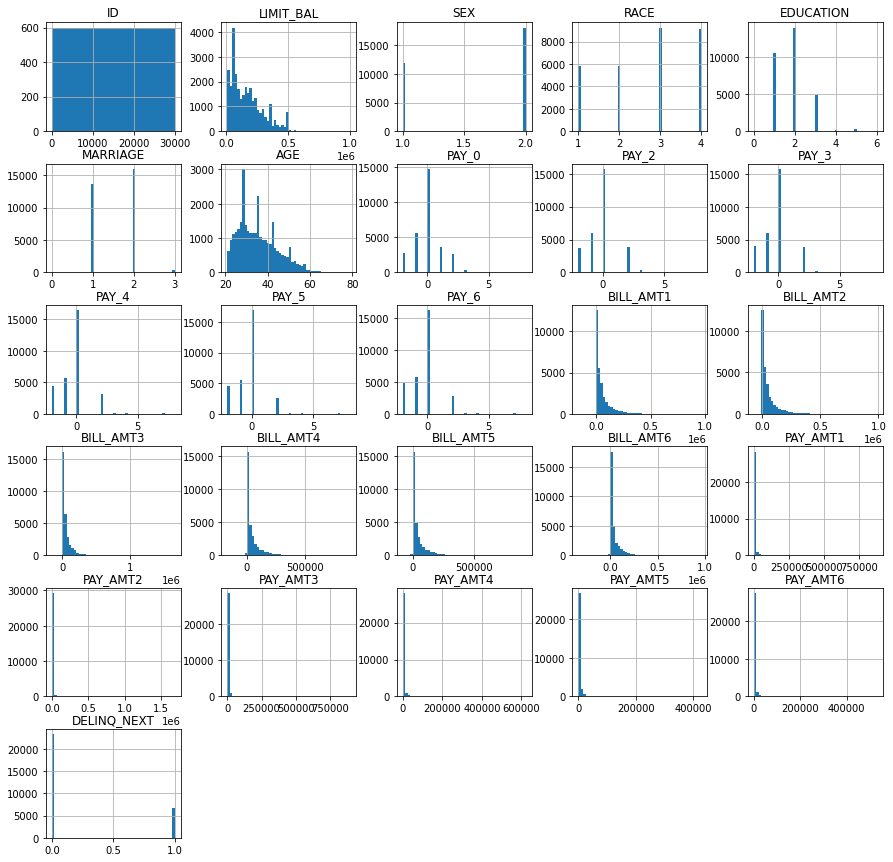

In [11]:
_ = data[data.columns].hist(bins=50, figsize=(15, 15)) # display histograms

In [12]:
# Pearson correlation matrix
corr = data.corr() 
corr

ID  LIMIT_BAL       SEX  ...  PAY_AMT5  PAY_AMT6  DELINQ_NEXT
ID           1.000000   0.026179  0.018497  ...  0.000652  0.003000    -0.013952
LIMIT_BAL    0.026179   1.000000  0.024755  ...  0.217202  0.219595    -0.153520
SEX          0.018497   0.024755  1.000000  ... -0.001667 -0.002766    -0.039961
RACE        -0.000710   0.044173  0.006149  ...  0.022148  0.020259    -0.303811
EDUCATION    0.039177  -0.219161  0.014232  ... -0.040358 -0.037200     0.028006
MARRIAGE    -0.029079  -0.108139 -0.031389  ... -0.001205 -0.006641    -0.024339
AGE          0.018678   0.144713 -0.090874  ...  0.022850  0.019478     0.013890
PAY_0       -0.030575  -0.271214 -0.057643  ... -0.058190 -0.058673     0.324794
PAY_2       -0.011215  -0.296382 -0.070771  ... -0.037093 -0.036500     0.263551
PAY_3       -0.018494  -0.286123 -0.066096  ... -0.035863 -0.035861     0.235253
PAY_4       -0.002735  -0.267460 -0.060173  ... -0.033590 -0.026565     0.216614
PAY_5       -0.022199  -0.249411 -0.055064  ... -0.033337 -0.023027     0.204149
PAY_6       -0.020270  -0.235195 -0.044008  ... -0.046434 -0.025299     0.186866
BILL_AMT1    0.019389   0.285430 -0.033642  ...  0.167026  0.179341    -0.019644
BILL_AMT2    0.017982   0.278314 -0.031183  ...  0.157957  0.174256    -0.014193
BILL_AMT3    0.024354   0.283236 -0.024563  ...  0.179712  0.182326    -0.014076
BILL_AMT4    0.040351   0.293988 -0.021880  ...  0.160433  0.177637    -0.010156
BILL_AMT5    0.016705   0.295562 -0.017005  ...  0.141574  0.164184    -0.006760
BILL_AMT6    0.016730   0.290389 -0.016733  ...  0.307729  0.115494    -0.005372
PAY_AMT1     0.009742   0.195236 -0.000242  ...  0.148459  0.185735    -0.072929
PAY_AMT2     0.008406   0.178408 -0.001391  ...  0.180908  0.157634    -0.058579
PAY_AMT3     0.039151   0.210167 -0.008597  ...  0.159214  0.162740    -0.056250
PAY_AMT4     0.007793   0.203242 -0.002229  ...  0.151830  0.157834    -0.056827
PAY_AMT5     0.000652   0.217202 -0.001667  ...  1.000000  0.154896    -0.055124
PAY_AMT6     0.003000   0.219595 -0.002766  ...  0.154896  1.000000    -0.053183
DELINQ_NEXT -0.013952  -0.153520 -0.039961  ... -0.055124 -0.053183     1.000000

[26 rows x 26 columns]

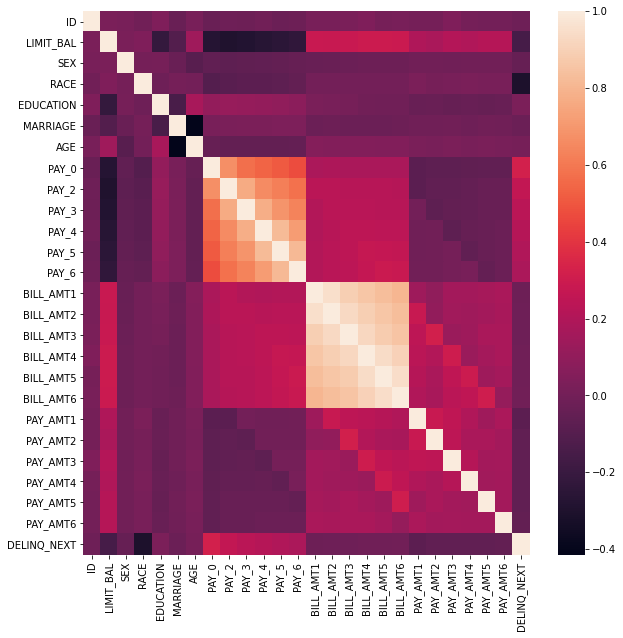

In [13]:
# correlation heatmap
plt.figure(figsize=(10, 10))
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

#### Train decision tree 

In [14]:
# assign basic modeling roles
# do not put demographic variables into a financial model!
y_name = 'DELINQ_NEXT'
X_names = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [15]:
# partition data for honest assessment
train_X, valid_test_X, train_y, valid_test_y = train_test_split(data[X_names], data[y_name], test_size=0.5, random_state=SEED) # split off training data
valid_X, test_X, valid_y, test_y = train_test_split(valid_test_X, valid_test_y, test_size=0.5, random_state=SEED) # split remainder into validation and test

# summarize 
print('Training data: %i rows and %i columns' % (train_X.shape[0], train_X.shape[1] + 1))
print('Validation data: %i rows and %i columns' % (valid_X.shape[0], valid_X.shape[1] + 1))
print('Testing data: %i rows and %i columns' % (test_X.shape[0], test_X.shape[1] + 1))

# housekeeping
del valid_test_X 
del valid_test_y

Training data: 15000 rows and 20 columns
Validation data: 7500 rows and 20 columns
Testing data: 7500 rows and 20 columns


In [16]:
# train decision tree 
# with validation-based early stopping
max_depth = 12
candidate_models = {}

# cycle through tree depths to find best model
# in validation data !!!
for depth in range(0, max_depth):

  # fit a model at max_depth=depth+1
  clf = tree.DecisionTreeClassifier(max_depth = depth + 1)
  clf.fit(train_X, train_y)

  # score training and validation data
  train_phat = clf.predict_proba(train_X)[:, 1]
  valid_phat = clf.predict_proba(valid_X)[:, 1]

  # calculate AUC to asses performance quality
  train_auc = roc_auc_score(train_y, train_phat)
  valid_auc = roc_auc_score(valid_y, valid_phat)

  # calculate cross validation scores to assess stability
  # in validation data!
  cv_scores = cross_val_score(clf, valid_X, valid_y, scoring='roc_auc', cv=5)
  cv_std = np.std(cv_scores)

  # store results
  # to analyze and select best model later
  candidate_models[depth + 1] = {} # dictionary inside a dictionary - it's ok!
  candidate_models[depth + 1]['Model'] = clf
  candidate_models[depth + 1]['Training AUC'] = train_auc
  candidate_models[depth + 1]['Validation AUC'] = valid_auc
  candidate_models[depth + 1]['5-Fold SD'] = cv_std

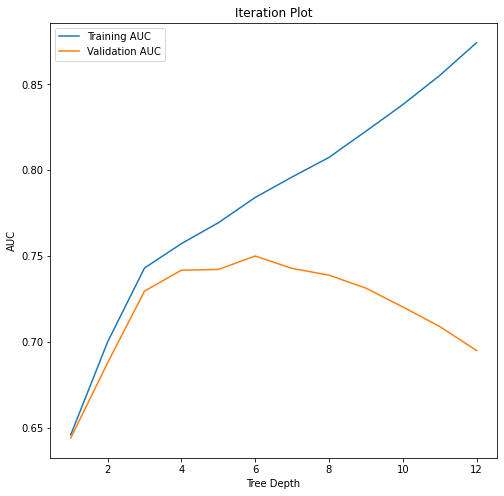

In [17]:
# plot tree depth vs. training and validation AUC
# using simple pandas plotting and matplotlib
candidate_results = pd.DataFrame.from_dict(candidate_models, orient='index') # turn nested dictionary into dataframe directly
fig, ax = plt.subplots(figsize=(8, 8))
_ = candidate_results[['Training AUC', 'Validation AUC']].plot(title='Iteration Plot', ax=ax) # links to axis initiated above
_ = ax.set_xlabel('Tree Depth') # x-axis label
_ = ax.set_ylabel('AUC') # y-axis label

In [18]:
 # veiw same results as a table, using pandas iloc to remove first column of table
candidate_results.iloc[:, 1:]

Training AUC  Validation AUC  5-Fold SD
1       0.645748        0.643880   0.009275
2       0.699912        0.687752   0.012626
3       0.742968        0.729490   0.017401
4       0.757178        0.741696   0.017045
5       0.769331        0.742119   0.019798
6       0.784074        0.749947   0.017914
7       0.796007        0.742734   0.023093
8       0.807421        0.738796   0.014656
9       0.822672        0.731243   0.006478
10      0.838170        0.720270   0.009451
11      0.855155        0.708884   0.007077
12      0.874275        0.694887   0.010601

In [19]:
# plot the tree for human interpretation
best_model = candidate_models[6]['Model']
fig = plt.figure(figsize=(400, 70))
_ = tree.plot_tree(best_model,
                   feature_names=X_names,
                   class_names=['On time', 'Delinquent'],
                   filled=True)

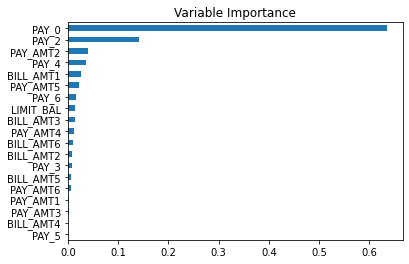

In [20]:
# plot variable importances

# create pandas dataframe
importances = pd.DataFrame(best_model.feature_importances_,
                           index=X_names,
                           columns=['Importance'])

# plot dataframe values
_ = importances.sort_values(by='Importance').plot(kind='barh', title='Variable Importance', legend=False)

In [21]:
# score on test data for 
# final HONEST assessment
# this is not to see how well the model *did*!
# it's to get an assessment of how it *will do* on unseen data!
test_phat = best_model.predict_proba(test_X)[:, 1] # get scores on test data
print('Test AUC: %.4f' % roc_auc_score(test_y, test_phat))

Test AUC: 0.7436


#### Function to create confusion matrices

In [22]:
# function for confusion matrices
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    # determine levels of target(y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list],
                            index=['predicted: ' + str(i) for i in level_list])

    # don't destroy original data
    frame_ = frame.copy(deep=True)

    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)

    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]

    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]

    # output results
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))

    return cm_frame

#### Function to calculate AIR

In [23]:
# function for AIR
def air(cm_dict, reference_key, protected_key, verbose=True):

    eps = 1e-20 # numeric stability and divide by 0 protection

    # reference group summary
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)

    # protected group summary
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    return ((protected_prop + eps)/(reference_prop + eps))

#### Bias testing

In [24]:
# add probabilities onto validation set
# note we need a probability cutoff to make a final lending decision
valid_yhat = pd.DataFrame(valid_X, columns=X_names)
valid_yhat['RACE'] = data.loc[valid_yhat.index, 'RACE']
valid_yhat['SEX'] = data.loc[valid_yhat.index, 'SEX']
valid_yhat[y_name]  = valid_y
valid_yhat['phat'] = best_model.predict_proba(valid_X)[:, 1]
valid_yhat.head()

LIMIT_BAL  PAY_0  PAY_2  PAY_3  ...  RACE  SEX  DELINQ_NEXT      phat
10752     470000      0      0      0  ...   3.0    1            0  0.070193
24174     260000     -1      0      0  ...   1.0    1            0  0.070193
13524      80000      0      0      0  ...   3.0    2            0  0.119735
13049      50000      1      2      0  ...   3.0    2            1  0.372789
23427     200000      1      2      0  ...   3.0    2            0  0.372789

[5 rows x 23 columns]

In [25]:
# calculate confusion matrices across race groups
# calculate confusion matrices at standard cutoff 0.15
# calculate AIR
race_dict = {'hispanic': 1,
             'black': 2,
             'white': 3,
             'asian': 4}

race_group_names = list(race_dict.keys())
race_cm_dict = {}

# calculate confusion matrices at standard cutoff 0.15
for name in race_group_names:
    race_cm_dict[name] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='RACE', level=race_dict[name], cutoff=0.15)
    print(race_cm_dict[name])
    print('(%s)' % name.title())
    print()

# calculate AIR
for name in race_group_names:
   if name != 'white':
      print('%s-to-%s AIR: %.2f' % (name, 'white', air(race_cm_dict, 'white', name)))
      print()

Confusion matrix by RACE=1
             actual: 1 actual: 0
predicted: 1       449       386
predicted: 0       137       502
(Hispanic)

Confusion matrix by RACE=2
             actual: 1 actual: 0
predicted: 1       448       351
predicted: 0       158       534
(Black)

Confusion matrix by RACE=3
             actual: 1 actual: 0
predicted: 1       177       813
predicted: 0        71      1228
(White)

Confusion matrix by RACE=4
             actual: 1 actual: 0
predicted: 1       186       785
predicted: 0        59      1216
(Asian)

White proportion accepted: 0.567
Hispanic proportion accepted: 0.434
hispanic-to-white AIR: 0.76

White proportion accepted: 0.567
Black proportion accepted: 0.464
black-to-white AIR: 0.82

White proportion accepted: 0.567
Asian proportion accepted: 0.568
asian-to-white AIR: 1.00



In [26]:
# calculate confusion matrices across sex groups
# calculate confusion matrices at standard cutoff 0.15
# calculate AIR
sex_dict = {'male': 1,
            'female': 2}

sex_group_names = list(sex_dict.keys())
sex_cm_dict = {}

# calculate confusion matrices at standard cutoff 0.15
for name in sex_group_names:
    sex_cm_dict[name] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='SEX', level=sex_dict[name], cutoff=0.15)
    print(sex_cm_dict[name])
    print('(%s)' % name.title())
    print()

# calculate AIR
for name in sex_group_names:
   if name != 'male':
      print('%s-to-%s AIR: %.2f' % (name, 'male', air(sex_cm_dict, 'male', name)))
      print()

Confusion matrix by SEX=1
             actual: 1 actual: 0
predicted: 1       544       907
predicted: 0       181      1290
(Male)

Confusion matrix by SEX=2
             actual: 1 actual: 0
predicted: 1       716      1428
predicted: 0       244      2190
(Female)

Male proportion accepted: 0.503
Female proportion accepted: 0.532
female-to-male AIR: 1.06



#### Bias Remediation

In [27]:
# function to calculate accuracy at a certain probability cutoff
def get_acc(frame, cutoff, y_name, yhat_name):

  temp = frame.copy(deep=True) # do not alter original data
  temp['decision'] = np.where(temp[yhat_name] > cutoff , 1, 0)
  acc = accuracy_score(temp[y_name], temp['decision'])
  del temp
  return acc

In [28]:
# observe accuracy trend as cutoff increases
# the problem is: higher cutoff means lending more money, even if more accurate
for cutoff in np.arange(0.1, 0.31, 0.01):
  print('Accuracy at cutoff %.2f is: %.4f' % (np.round(cutoff, 2), get_acc(valid_yhat, np.round(cutoff, 2), y_name, 'phat'))) 

Accuracy at cutoff 0.10 is: 0.4461
Accuracy at cutoff 0.11 is: 0.4905
Accuracy at cutoff 0.12 is: 0.6320
Accuracy at cutoff 0.13 is: 0.6320
Accuracy at cutoff 0.14 is: 0.6320
Accuracy at cutoff 0.15 is: 0.6320
Accuracy at cutoff 0.16 is: 0.6320
Accuracy at cutoff 0.17 is: 0.6320
Accuracy at cutoff 0.18 is: 0.7383
Accuracy at cutoff 0.19 is: 0.7629
Accuracy at cutoff 0.20 is: 0.7629
Accuracy at cutoff 0.21 is: 0.7629
Accuracy at cutoff 0.22 is: 0.7629
Accuracy at cutoff 0.23 is: 0.7629
Accuracy at cutoff 0.24 is: 0.7629
Accuracy at cutoff 0.25 is: 0.7713
Accuracy at cutoff 0.26 is: 0.7713
Accuracy at cutoff 0.27 is: 0.7713
Accuracy at cutoff 0.28 is: 0.7713
Accuracy at cutoff 0.29 is: 0.7713
Accuracy at cutoff 0.30 is: 0.7740


In [29]:
# recalculate AIR and confusion matrices at different cutoff
# recalculate race confusion matrices at different cutoff
for name in race_group_names:
    race_cm_dict[name] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='RACE', level=race_dict[name], cutoff=0.18, verbose=False)

# recalculate race AIR
for name in race_group_names:
   if name != 'white':
      print('%s-to-%s AIR: %.2f' % (name, 'white', air(race_cm_dict, 'white', name)))
      print()

# calculate sex confusion matrices at different cutoff
for name in sex_group_names:
    sex_cm_dict[name] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='SEX', level=sex_dict[name], cutoff=0.18, verbose=False)

# calculate race AIR
for name in sex_group_names:
   if name != 'male':
      print('%s-to-%s AIR: %.2f' % (name, 'male', air(sex_cm_dict, 'male', name)))
      print()

White proportion accepted: 0.735
Hispanic proportion accepted: 0.612
hispanic-to-white AIR: 0.83

White proportion accepted: 0.735
Black proportion accepted: 0.625
black-to-white AIR: 0.85

White proportion accepted: 0.735
Asian proportion accepted: 0.738
asian-to-white AIR: 1.00

Male proportion accepted: 0.682
Female proportion accepted: 0.695
female-to-male AIR: 1.02



In [30]:
# redo model search with new information
# train decision tree 
# with validation-based early stopping
# and AIR calculation!
max_depth = 12
candidate_models = {}

# cycle through tree depths to find best model
# in validation data !!!
for depth in range(0, max_depth):

  # fit a model at max_depth=depth+1
  clf = tree.DecisionTreeClassifier(max_depth = depth + 1, random_state=SEED)
  clf.fit(train_X, train_y)

  # score training and validation data
  train_phat = clf.predict_proba(train_X)[:, 1]
  valid_phat = clf.predict_proba(valid_X)[:, 1]

  # calculate AUC to asses performance quality
  train_auc = roc_auc_score(train_y, train_phat)
  valid_auc = roc_auc_score(valid_y, valid_phat)

  # calculate AIR to access performance quality
  valid_yhat = pd.DataFrame(valid_X, columns=X_names)
  valid_yhat['RACE'] = data.loc[valid_yhat.index, 'RACE']
  valid_yhat[y_name] = valid_y
  valid_yhat['phat'] = valid_phat
  cm_dict = {}
  cm_dict['white'] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='RACE', level=3, cutoff=0.18, verbose=False)
  cm_dict['hispanic'] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='RACE', level=1, cutoff=0.18, verbose=False)
  valid_hispanic_air = air(cm_dict, 'white', 'hispanic', verbose=False)

  # calculate cross validation scores to assess stability
  # in validation data!
  cv_scores = cross_val_score(clf, valid_X, valid_y, scoring='roc_auc', cv=5)
  cv_std = np.std(cv_scores)

  # store results
  # to analyze and select best model later
  candidate_models[depth + 1] = {} # dictionary inside a dictionary - it's ok!
  candidate_models[depth + 1]['Model'] = clf
  candidate_models[depth + 1]['Training AUC'] = train_auc
  candidate_models[depth + 1]['Validation AUC'] = valid_auc
  candidate_models[depth + 1]['5-Fold SD'] = cv_std
  candidate_models[depth + 1]['Hispanic-to-White AIR'] = valid_hispanic_air

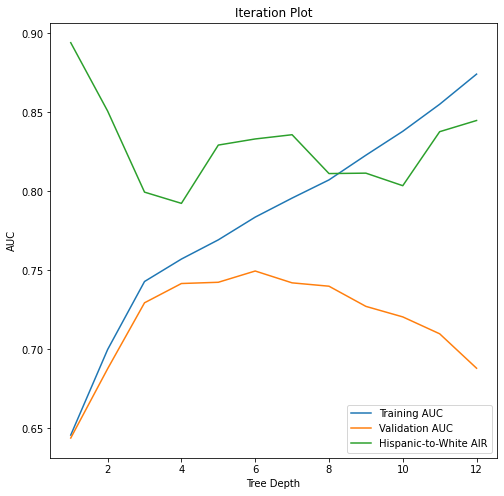

In [31]:
# plot tree depth vs. training and validation AUC and AIR
# using simple pandas plotting and matplotlib
candidate_results = pd.DataFrame.from_dict(candidate_models, orient='index') # turn nested dictionary into dataframe directly
fig, ax = plt.subplots(figsize=(8, 8))
_ = candidate_results[['Training AUC', 'Validation AUC', 'Hispanic-to-White AIR']].plot(title='Iteration Plot', ax=ax) # links to axis initiated above
_ = ax.set_xlabel('Tree Depth') # x-axis label
_ = ax.set_ylabel('AUC') # y-axis label

Turns out `depth=6` was a good choice for a final model!
* **Training AUC**: 0.78
* **Validation AUC**: 0.75
* **Test AUC**: 0.74
* **Asian-to-White AIR**: 1.00
* **Black-to-White AIR**: 0.85
* **Female-to-Male AIR**: 1.02
* **Hispanic-to-White AIR**: 0.83